## **Credit Card Customer Segmentation**

In this project, we’ll be working for a credit card company. 

### Introduction

The dataset contains information about the company’s clients and we're asked to help segment them into different groups in order to apply different business strategies for each type of customer.

The company expects to receive a group for each client and an explanation of the characteristics of each group and the main points that make them different.

Inorder to implement our algorithm properly, we will go through the following steps:
1. Analyze the dataset
2. Prepare the data for modelling
3. Find an appropriate number of clusters
4. Analyze results
5. Interpret and explain the results

Below is the data dictionary:

- **customer_id**: unique identifier for each customer.
- **age**: customer age in years.
- **gender**: customer gender (M or F).
- **dependent_count**: number of dependents of each customer.
- **education_level**: level of education ("High School", "Graduate", etc.).
- **marital_status**: marital status ("Single", "Married", etc.).
- **estimated_income**: the estimated income for the customer projected by the data science team.
- **months_on_book**: time as a customer in months.
- **total_relationship_count**: number of times the customer contacted the company.
- **months_inactive_12_mon**: number of months the customer did not use the credit card in the last 12 months.
- **credit_limit**: customer's credit limit.
- **total_trans_amount**: the overall amount of money spent on the card by the customer.
- **total_trans_count**: the overall number of times the customer used the card.
- **avg_utilization_ratio**: daily average utilization ratio.

### 1. Analyze the Dataset

We would be exploring our dataset to find reasonable insights

In [1]:
#import the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
#read in the dataset
customers = pd.read_csv('customer_segmentation.csv')
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [3]:
#print the info on the dataset
customers.info()
customers.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

(10127, 14)

The dataset comprises of 14 columns and 10127 rows. We can observe that there are no missing values in our dataset. There are 3 columns with with categorical data. We would convert them to numerical values.

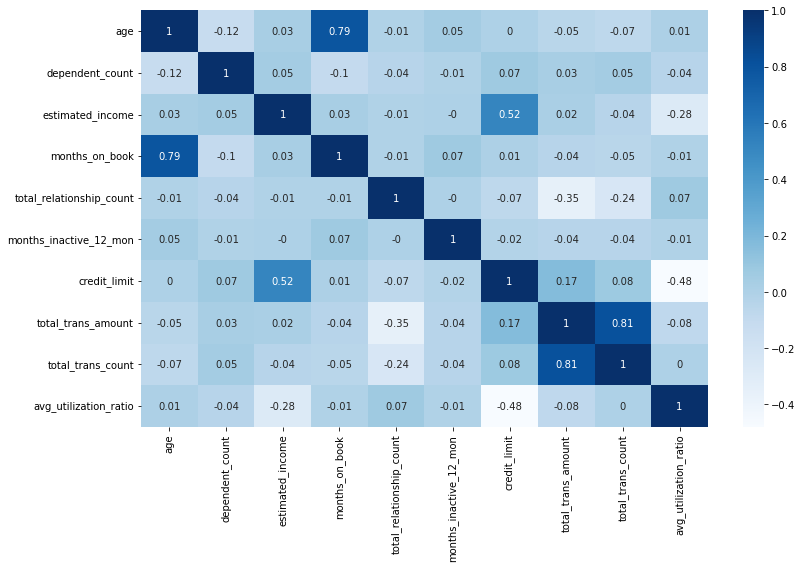

In [4]:
#show the correlation between columns
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(round(customers.drop('customer_id', axis=1).corr(), 2), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

From the observations, we can see that some columns are more correlated than the others:

- Age is strongly correlated with how long the person has been a customer (months_on_book)
- Credit limit is positively correlated with the estimated income and negatively correlated with the average utilization ratio
- The total number of transactions (total_trans_count) is strongly correlated with the total amount transitioned (total_trans_amount).

C:\Users\SMARTEX\AppData\Local\Temp/ipykernel_10492/4252282034.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  customers.drop('customer_id', axis=1).hist(ax=ax)


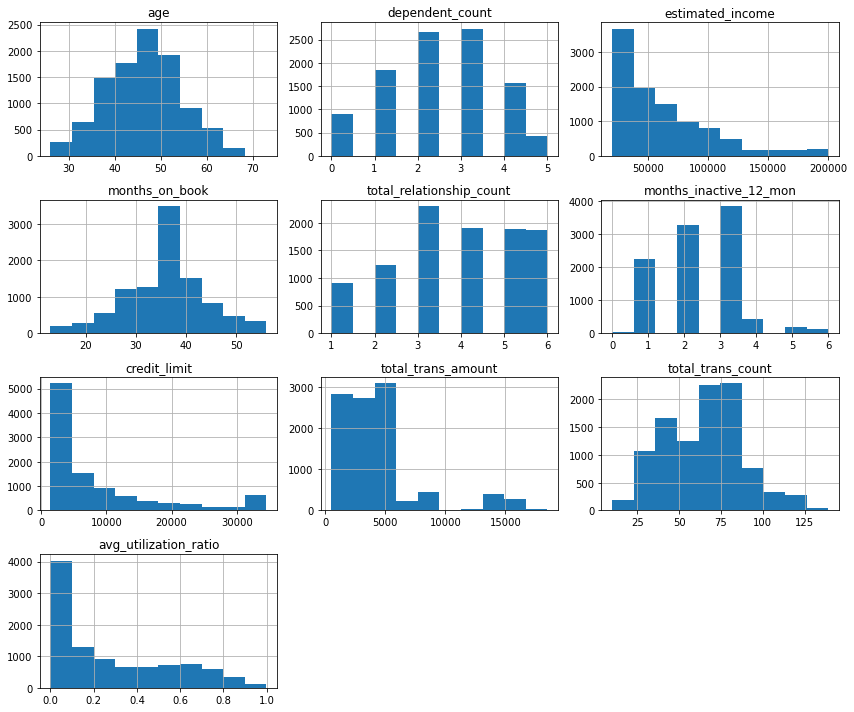

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))

#Removing the customer's id before plotting the distributions
customers.drop('customer_id', axis=1).hist(ax=ax)

plt.tight_layout()
plt.show()

### Observations

Below are some of the insights from the column distributions:
- Most of the customers are within the age range of 40-60
-  The estimated_income distribution is right skewed. We can see that most of the customers earn less than 100,000 dollars
- From the total_transaction_amount distribution, we find out that the most of the customers have a total transaction amount less than or equal to 6000 dollars.

### 2. Data Preparation

Let's start dealing with the categorical columns. There are three of them: gender, education level, and marital status.

The gender column contains only 2 unique values, "M" and "F", which means it's possible to replace all the rows with 1 and 0.

The education_level column contains 6 unique values. This column represents levels of education, and it's possible to rank the levels from the lowest to the highest, so it's possible to replace each unique level with a number, assuming we respect the order.

In [6]:
# create a copy of the original dataframe
customers_modif = customers.copy()

# replace the values in the gender column 
customers_modif['gender'] = customers_modif['gender'].replace(['M','F'],[1,0])

# replace the values in the education_level
customers_modif['education_level'] = customers_modif['education_level'].replace(
    ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'],
    [0,1,2,3,4,5])

Now, let's deal with the marital_status columns. Unlike the educational_level column, there is no level of magnitude between "Single", "Married" or "Divorced". We can't say that any of them is higher or better than the others, hence, we can't rank these categories objectively. We will use one-hot-encoding to create dummy variables from this column. 

In [7]:
# use the pandas.get_dummies function to create dummy variables
customers_modif = pd.get_dummies(customers_modif, columns= ['marital_status'], drop_first=True)

Now that we have dealt with the categorical columns in our dataset, let us continue with transforming our data so its on the same range. 

In [8]:
# drop the customer_id column
customers_modif = customers_modif.drop(['customer_id'], axis=1)
column = customers_modif.columns
customers_modif.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


In [9]:
#instantiate the scaler and scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(customers_modif)
customers_scaled = pd.DataFrame(data = scaled, columns = column)

### 3. Choosing the Appropriate Number of Clusters

Now our dataset has been scaled and is ready for modelling. The next step is to decide the best number of clusters to use in the segmentation according to the inertia metric.

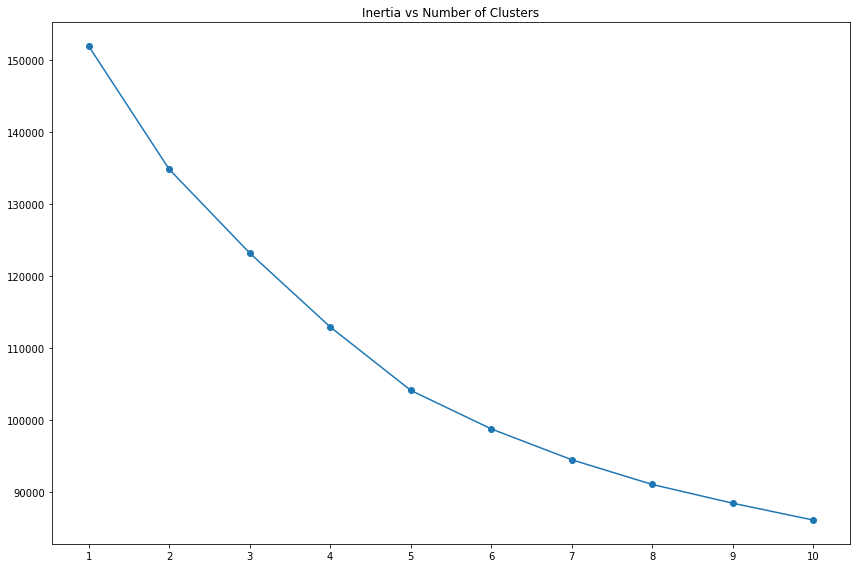

[151904.99999999994, 134790.4045018768, 123153.4317342493, 112889.69065115844, 104079.24817700154, 98723.44587110273, 94437.05907741186, 91007.18191867309, 88400.6388046524, 86058.37690588205]


In [10]:
#plot a graph of inertias to help determine the number of clusters
inertias = []

for i in range(1,11):
    model = KMeans(n_clusters=i)
    cluster = model.fit_predict(customers_scaled)
    inertias.append(model.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show() 

print(inertias)

Close examination of the graph of Inertias above will shows a not too distinct elbow at the 5 clusters mark. For fruther modelling, we would be using 5 as our n_cluster. 

In [11]:
#instantiate a new KMeans object 
k_model = KMeans(n_clusters=5, random_state=9)
clusters = k_model.fit_predict(customers_scaled)
print(clusters)

[4 1 4 ... 0 3 0]


### 4. Analyze Results

In [12]:
customers['Cluster']= clusters +1
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,Cluster
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,5
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,2
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,5
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,4
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,3
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,2
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,1
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,4


In [13]:
customers['Cluster'].value_counts()

1    3450
2    2963
5    2011
3     964
4     739
Name: Cluster, dtype: int64

We can see that cluster 1 is the largest while cluster 5 is the smallest.

Considering the numeric variable only, we'll check on the average value of each variable per cluster. We just need to group the data and plot a bar chart for each column.

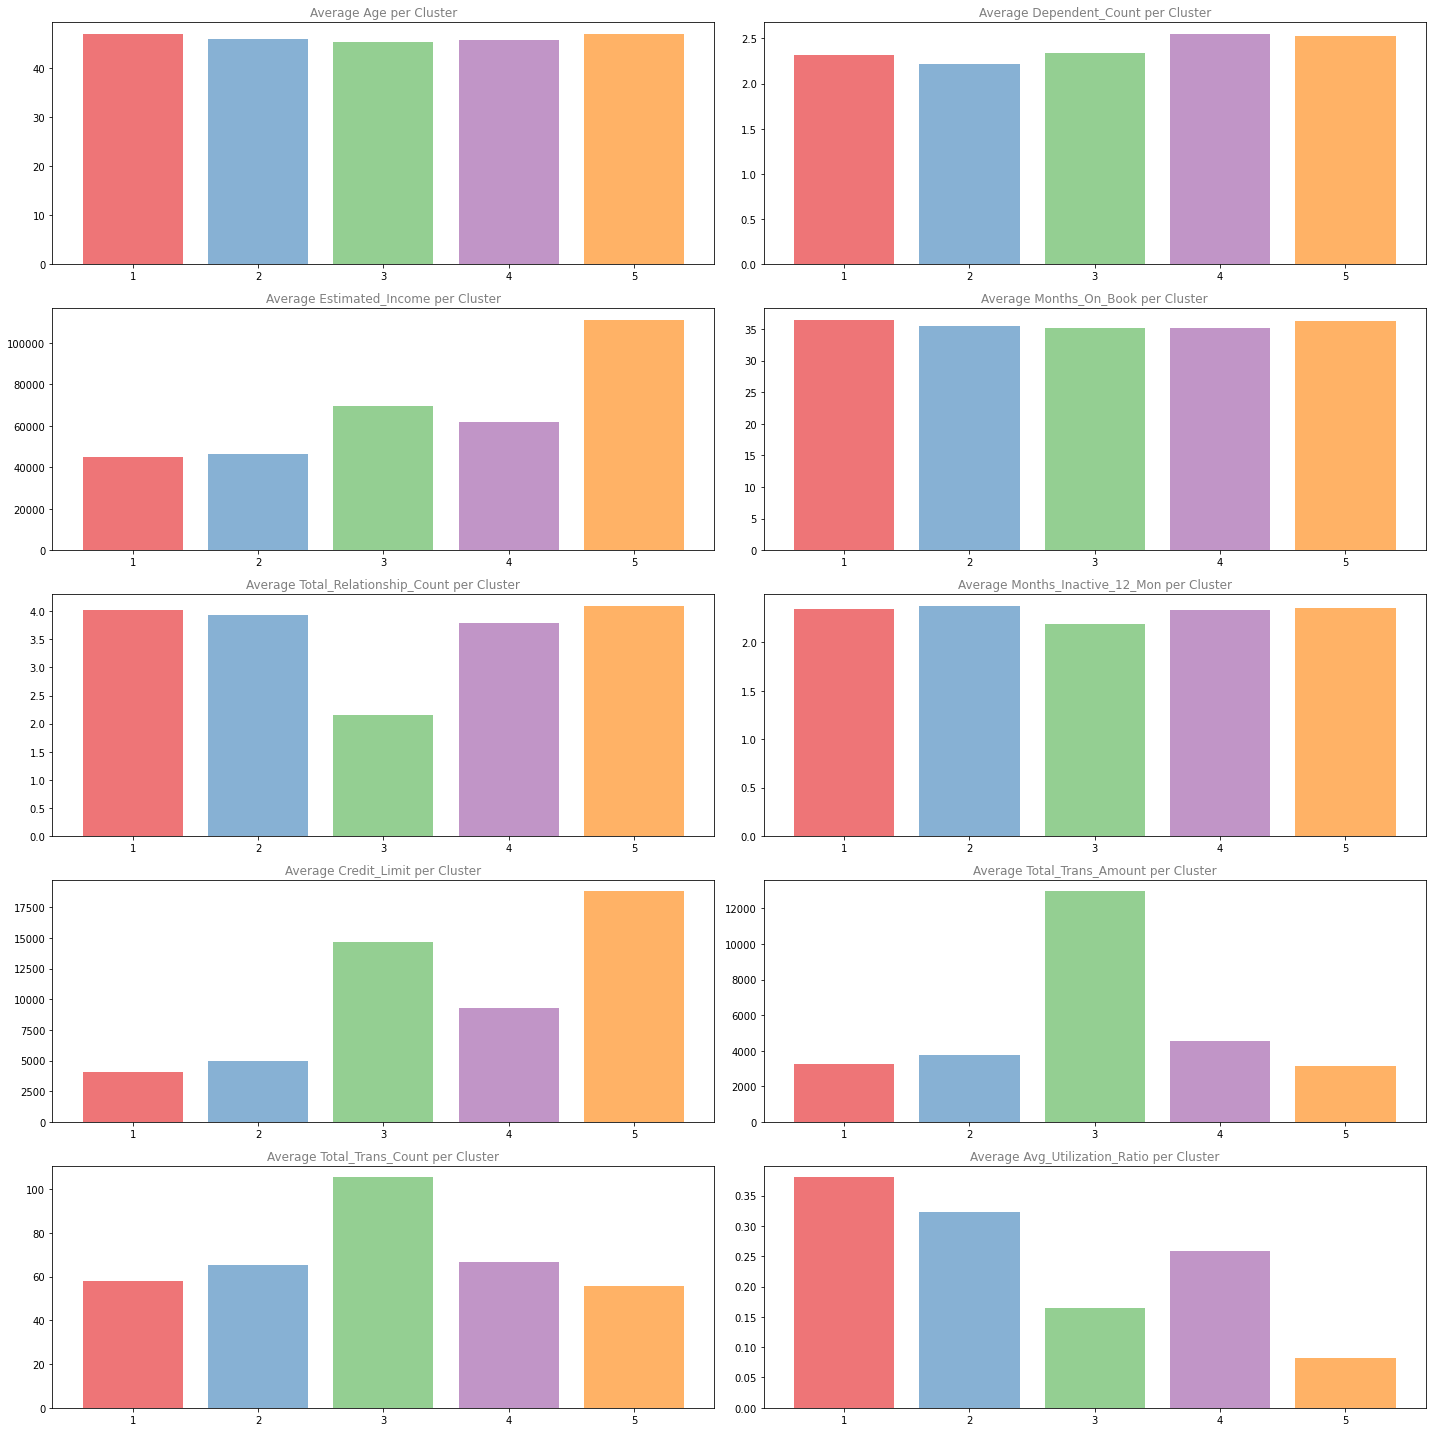

In [14]:
#plot a bar chart for the numeric columns
numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'Cluster'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('Cluster')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

For those numerical variables with higher correlations we saw earlier, we can also use a scatter plot to visualize this correlation grouped by clusters and analyze how the clusters change between each area of the chart.

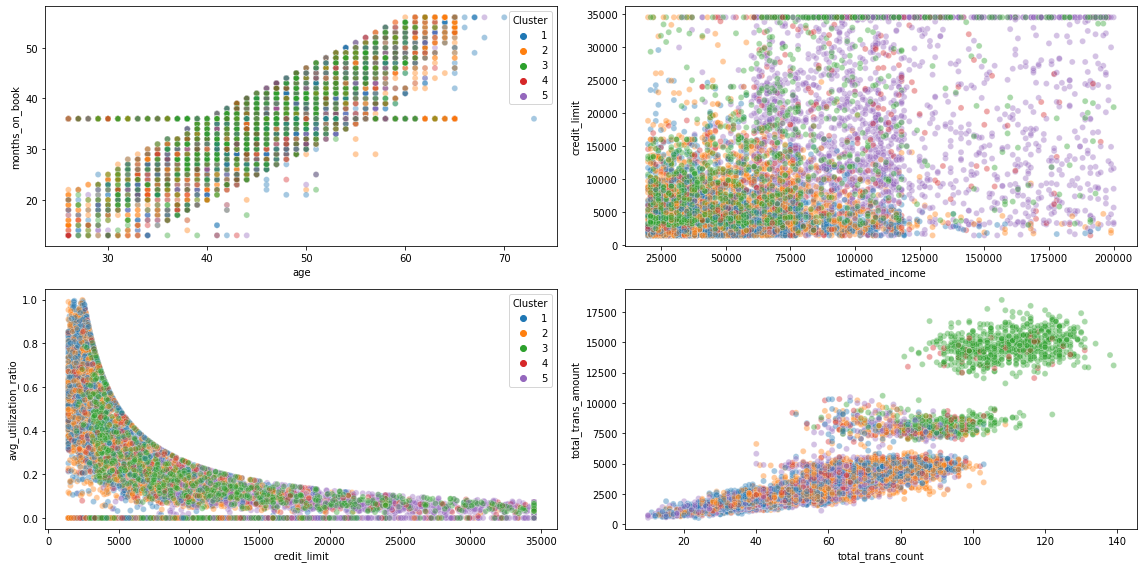

In [15]:
#plot a scatterplot for the columns with high correlatons
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='Cluster', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='Cluster', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='Cluster', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='Cluster', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

### Observations

From the graph of the clusters above, we make the following observations
- Cluster 4 has older clients.
- Cluster 3 comprises of middle income earners with the highest spent amount.
- Cluster 5 has customers with the highest income but lowest spent amount.
- Cluster 1 & 2 appears to be similar with low income and high average utilization.

For the categorical columns, we'll plot the percentual distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, or of married people only, for example.

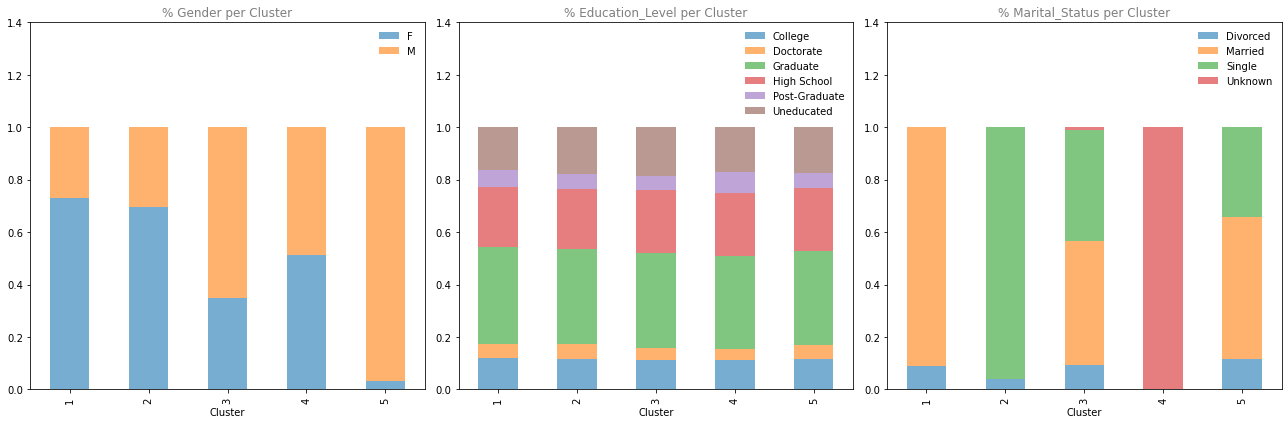

In [16]:
categorical_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, column in enumerate(categorical_columns):
    plot_df = pd.crosstab(index=customers['Cluster'], columns=customers[column], values=customers[column], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {column.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    

plt.tight_layout()
plt.show()

From graph of the categorical data, we can see that cluster 5 comprises of mostly male clients while cluster 1 & 2 has more females. 

The educational level is evenly distributed between clusters. 

Clients on cluster 4 have their marital status Unknown.

Cluster 1 has more married clients while Cluster 2 has more single clients.

### Conclusion

As demanded by the company, we now have listed the most important characteristics of each cluster. We could also some suggestions and insights into each one of them.

In the end, we have the list of customers with a cluster assigned to each one.

#### Cluster 1
**Characteristics**: Mostly females; mostly married; low estimated income; low credit limit; low amount transitioned; high utilization rate.
#### Cluster 2
**Characteristics**: Mostly females; mostly single; low estimated income; low credit limit; low amount transitioned; high utilization rate.
#### Cluster 3
**Characteristics**: Mostly males;; mostly middle aged; middle income earners; average credit limit; highest amount transitioned; low utilization rate.
#### Cluster 4
**Characteristics**: Gender well divided; Mostly older aged customers; middle income earners; low amount transitioned; average utilization rate.
#### Cluster 5
**Characteristics**: Mostly males; high estimated income; high credit limit; low amount transitioned; low utilization rate.

### Business Insights

Cluster 1 & 2 are married people (majority women) with low income and limit but utilize too much of their credit with a few larger purchases. Increase monthly transaction amount through incentives to maximize revenue from fees from the transactions.

Cluster 3 are mostly middle income earners with high volume spent on the card, but do not use it on a daily basis. They could be incentivised to spend more.

Cluster 4 are mostly older aged customers and longer customers, could be pensioniers but use the card very often. They could receive benefits to spend more money.

Cluster 5 are majorly males with high income and credit limits, but don't use the card. They could be incentivized to use it.